In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.impute import KNNImputer
from plotly import graph_objects as go
import math as mth
from scipy import stats as st
import re
import json
import warnings; 
warnings.filterwarnings(action='ignore')
import plotly.io as pio


In [2]:
# Определяем путь к файлу
file_path = r"C:\Users\Matvey\Desktop\Sber\output.csv"

# Открываем файл и считываем его содержимое как DataFrame
try:
    df = pd.read_csv(file_path, sep=',', encoding='utf-8')  

    # Удаляем символ " из всех ячеек DataFrame
    df = df.applymap(lambda x: x.replace('"', '') if isinstance(x, str) else x)

    # Сохраняем измененный DataFrame обратно в CSV файл
    df.to_csv(file_path, index=False, encoding='utf-8')

except FileNotFoundError:
    print("Ошибка: файл не найден. Проверьте путь к файлу.")
except pd.errors.ParserError:
    print("Ошибка: не удалось разобрать файл. Проверьте разделитель.")
except Exception as e:
    print(f"Произошла ошибка: {e}")
df.head(5)

,tradedate,tradetime,secid,spread_bbo,spread_lv10,spread_1mio,levels_b,levels_s,vol_b,vol_s,...,val_s,imbalance_vol_bbo,imbalance_val_bbo,imbalance_vol,imbalance_val,vwap_b,vwap_s,vwap_b_1mio,vwap_s_1mio,SYSTIMEdata
0,2024-10-01,10:05:00,SBER,1.7,9.7,3.5,630,775,147639,202389,...,554560089,-0.03,-0.03,-0.16,-0.18,262.38,274.01,267.21,267.30,2024-10-01 10:05:14
1,2024-10-01,10:10:00,SBER,0.9,8.9,2.1,721,791,187671,205428,...,563675374,0.09,0.09,-0.05,-0.07,263.37,274.39,268.04,268.09,2024-10-01 10:10:14
2,2024-10-01,10:15:00,SBER,0.8,8.5,1.9,712,830,173292,232110,...,636033240,0.11,0.11,-0.15,-0.17,263.04,274.03,267.67,267.72,2024-10-01 10:15:14
3,2024-10-01,10:20:00,SBER,0.5,8.3,1.6,708,852,187907,247700,...,678179911,0.03,0.03,-0.14,-0.16,263.04,273.79,267.39,267.44,2024-10-01 10:20:14
4,2024-10-01,10:25:00,SBER,0.6,8.3,1.6,726,843,202408,250325,...,685474036,-0.20,-0.20,-0.11,-0.13,263.35,273.83,267.66,267.70,2024-10-01 10:25:15


In [3]:
# Увеличим максимальное количество и ширину отображающихся столбцов.
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 1


# Установка ширины столбцов для DataFrame
pd.set_option('display.max_colwidth', None)  # Установить неограниченную ширину столбцов

# Установление ограничения на показ знаков после запятой
pd.options.display.float_format = '{:,.2f}'.format

# Удаление лишних пробелов в названиях столбцов
df.columns = df.columns.str.strip()

# Приведение названий столбцов к нижнему регистру
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

# Преобразование столбца tradedate в datetime
df['tradedate'] = pd.to_datetime(df['tradedate'])

# Преобразование столбца systimedata в datetime
df['systimedata'] = pd.to_datetime(df['systimedata'])

# Удаление лишних пробелов в столбце tradetime и преобразование в формат времени
df['tradetime'] = df['tradetime'].astype(str).str.strip()  # Преобразуем в строку, затем удаляем пробелы
df['tradetime'] = pd.to_datetime(df['tradetime'], format='%H:%M:%S').dt.time

# # Объединение столбцов tradedate и tradetime в новый столбец datetime
# df['datetime'] = pd.to_datetime(df['tradedate'].astype(str) + ' ' + df['tradetime'].astype(str))

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   tradedate          1000 non-null   datetime64[ns]
 1   tradetime          1000 non-null   object        
 2   secid              1000 non-null   object        
 3   spread_bbo         1000 non-null   float64       
 4   spread_lv10        1000 non-null   float64       
 5   spread_1mio        1000 non-null   float64       
 6   levels_b           1000 non-null   int64         
 7   levels_s           1000 non-null   int64         
 8   vol_b              1000 non-null   int64         
 9   vol_s              1000 non-null   int64         
 10  val_b              1000 non-null   int64         
 11  val_s              1000 non-null   int64         
 12  imbalance_vol_bbo  1000 non-null   float64       
 13  imbalance_val_bbo  1000 non-null   float64       
 14  imbalance

In [21]:
num_rows = df.shape[0]
print("Количество строк в датасете:", num_rows)
df.head()

Количество строк в датасете: 1000


,tradedate,tradetime,secid,spread_bbo,spread_lv10,spread_1mio,levels_b,levels_s,vol_b,vol_s,val_b,val_s,imbalance_vol_bbo,imbalance_val_bbo,imbalance_vol,imbalance_val,vwap_b,vwap_s,vwap_b_1mio,vwap_s_1mio,systimedata
0,2024-10-01,10:05:00,SBER,1.70,9.70,3.50,630,775,147639,202389,387451611,554560089,-0.03,-0.03,-0.16,-0.18,262.38,274.01,267.21,267.30,2024-10-01 10:05:14
1,2024-10-01,10:10:00,SBER,0.90,8.90,2.10,721,791,187671,205428,494311737,563675374,0.09,0.09,-0.05,-0.07,263.37,274.39,268.04,268.09,2024-10-01 10:10:14
2,2024-10-01,10:15:00,SBER,0.80,8.50,1.90,712,830,173292,232110,455848293,636033240,0.11,0.11,-0.15,-0.17,263.04,274.03,267.67,267.72,2024-10-01 10:15:14
3,2024-10-01,10:20:00,SBER,0.50,8.30,1.60,708,852,187907,247700,494286488,678179911,0.03,0.03,-0.14,-0.16,263.04,273.79,267.39,267.44,2024-10-01 10:20:14
4,2024-10-01,10:25:00,SBER,0.60,8.30,1.60,726,843,202408,250325,533045495,685474036,-0.20,-0.20,-0.11,-0.13,263.35,273.83,267.66,267.70,2024-10-01 10:25:15


In [6]:
df.tradedate.sort_values(ascending = False)

999   2024-10-09
973   2024-10-09
980   2024-10-09
979   2024-10-09
978   2024-10-09
         ...    
107   2024-10-01
106   2024-10-01
105   2024-10-01
104   2024-10-01
0     2024-10-01
Name: tradedate, Length: 1000, dtype: datetime64[ns]

In [7]:
# Основное описание данных
description = df.describe()
description

,spread_bbo,spread_lv10,spread_1mio,levels_b,levels_s,vol_b,vol_s,val_b,val_s,imbalance_vol_bbo,imbalance_val_bbo,imbalance_vol,imbalance_val,vwap_b,vwap_s,vwap_b_1mio,vwap_s_1mio
count,"1,000.00","1,000.00","1,000.00","1,000.00","1,000.00","1,000.00","1,000.00","1,000.00","1,000.00","1,000.00","1,000.00","1,000.00","1,000.00","1,000.00","1,000.00","1,000.00","1,000.00"
mean,0.77,8.65,1.99,891.34,983.71,"337,766.84","409,283.57","869,167,915.58","1,102,993,588.45",-0.03,-0.03,-0.11,-0.13,257.36,269.59,263.39,263.44
std,0.33,0.78,0.74,137.83,115.12,"135,428.78","81,910.97","350,005,281.60","219,159,873.55",0.26,0.26,0.19,0.19,3.03,2.42,2.13,2.13
min,0.40,7.30,0.40,481.00,543.00,"118,056.00","190,112.00","299,985,203.00","510,093,254.00",-0.87,-0.87,-0.66,-0.68,248.47,265.42,257.85,257.88
25%,0.60,8.20,1.50,786.00,924.75,"260,421.00","357,613.00","677,877,163.25","968,922,318.50",-0.20,-0.20,-0.19,-0.21,255.65,267.61,262.44,262.49
50%,0.70,8.50,1.90,901.00,974.00,"329,255.00","405,165.50","837,816,433.50","1,084,765,122.00",-0.03,-0.03,-0.13,-0.15,256.90,268.62,263.24,263.28
75%,0.90,8.90,2.40,958.00,"1,035.25","376,257.75","470,229.25","963,408,481.25","1,264,893,140.75",0.13,0.13,-0.02,-0.04,259.25,271.96,264.68,264.74
max,3.30,15.90,5.60,"1,240.00","1,379.00","812,025.00","595,569.00","2,105,372,968.00","1,591,447,944.00",0.88,0.88,0.35,0.33,263.78,274.39,268.06,268.10


**Рассмотрим пропуски в датасете**

In [8]:
df.isna().sum()

tradedate            0
tradetime            0
secid                0
spread_bbo           0
spread_lv10          0
spread_1mio          0
levels_b             0
levels_s             0
vol_b                0
vol_s                0
val_b                0
val_s                0
imbalance_vol_bbo    0
imbalance_val_bbo    0
imbalance_vol        0
imbalance_val        0
vwap_b               0
vwap_s               0
vwap_b_1mio          0
vwap_s_1mio          0
systimedata          0
dtype: int64

**Рассмотрим датасет на наличие и неявных дубликатов.**

In [9]:
df.duplicated().sum()
print(f'Количество явных дубликатов: {df.duplicated().sum()}')

Количество явных дубликатов: 0


,spread_bbo,spread_lv10,spread_1mio,levels_b,levels_s,vol_b,vol_s,val_b,val_s,imbalance_vol_bbo,imbalance_val_bbo,imbalance_vol,imbalance_val,vwap_b,vwap_s,vwap_b_1mio,vwap_s_1mio
spread_bbo,1.00,0.68,0.77,0.08,-0.01,-0.10,0.07,-0.10,0.07,-0.06,-0.06,-0.11,-0.12,-0.09,0.07,-0.02,-0.02
spread_lv10,0.68,1.00,0.60,0.10,-0.03,-0.06,0.05,-0.07,0.05,-0.03,-0.03,-0.07,-0.07,-0.16,-0.02,-0.08,-0.08
spread_1mio,0.77,0.60,1.00,0.09,-0.04,-0.14,0.07,-0.14,0.07,-0.13,-0.13,-0.13,-0.13,-0.10,0.04,-0.02,-0.01
levels_b,0.08,0.10,0.09,1.00,-0.54,0.45,-0.10,0.44,-0.11,-0.10,-0.10,0.55,0.53,-0.42,-0.26,-0.07,-0.07
levels_s,-0.01,-0.03,-0.04,-0.54,1.00,-0.15,0.70,-0.15,0.70,-0.01,-0.01,-0.59,-0.58,-0.11,-0.14,-0.49,-0.49
vol_b,-0.10,-0.06,-0.14,0.45,-0.15,1.00,0.02,1.00,0.01,0.08,0.08,0.81,0.81,-0.03,-0.22,-0.05,-0.05
vol_s,0.07,0.05,0.07,-0.10,0.70,0.02,1.00,0.01,1.00,-0.12,-0.12,-0.53,-0.54,-0.43,-0.19,-0.56,-0.56
val_b,-0.10,-0.07,-0.14,0.44,-0.15,1.00,0.01,1.00,0.00,0.09,0.09,0.81,0.81,-0.01,-0.21,-0.03,-0.03
val_s,0.07,0.05,0.07,-0.11,0.70,0.01,1.00,0.00,1.00,-0.12,-0.12,-0.54,-0.54,-0.40,-0.15,-0.53,-0.53
imbalance_vol_bbo,-0.06,-0.03,-0.13,-0.10,-0.01,0.08,-0.12,0.09,-0.12,1.00,1.00,0.15,0.15,0.15,0.13,0.13,0.13


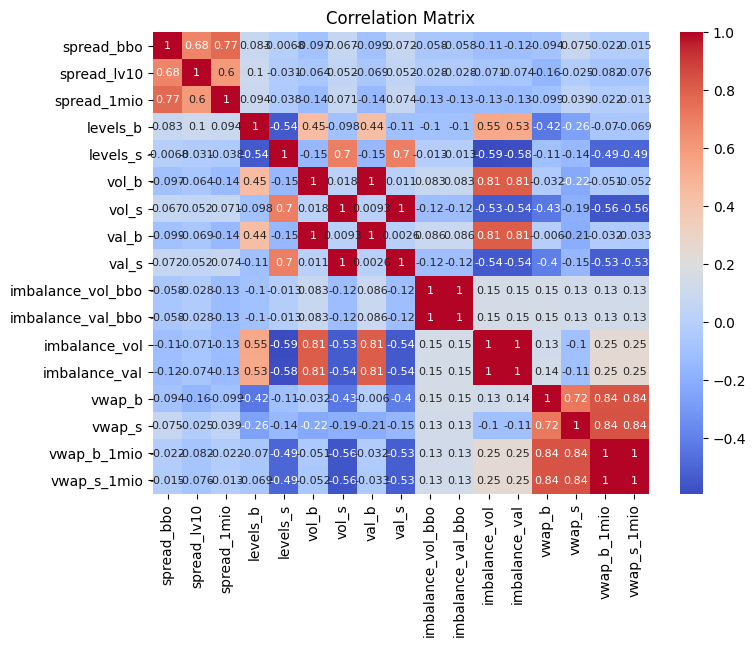

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Корреляционная матрица
correlation_matrix = df.corr()
display(correlation_matrix)

# Построение тепловой карты корреляций (Корреляционная матрица)
plt.figure(figsize=(8, 6))  # Уменьшение размера графика
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", annot_kws={"size": 8})  # Уменьшение шрифта
plt.title("Correlation Matrix")
plt.show()


На основе корреляционной матрицы можно выявить сильные взаимосвязи между переменными, такие как:

Корреляции между спредами (spread_bbo, spread_lv10, spread_1mio) и объемами сделок.
Взаимосвязь между средневзвешенной ценой покупки и продажи (vwap_b и vwap_s).
Этот анализ позволяет выделить потенциальные корреляции и временные тренды, которые могут быть полезны для более глубокого анализа данных.

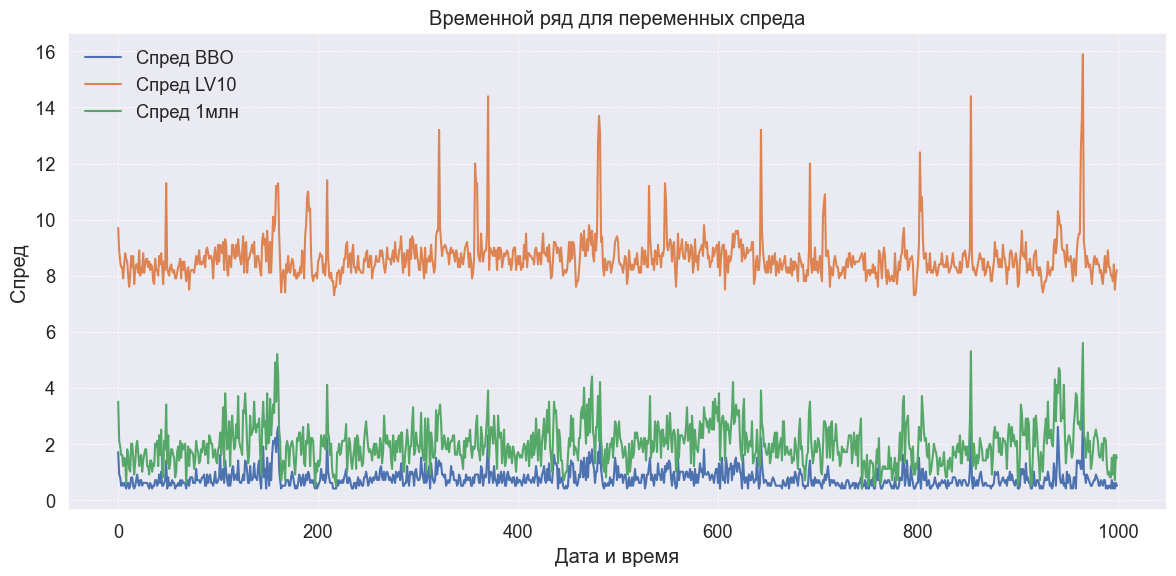

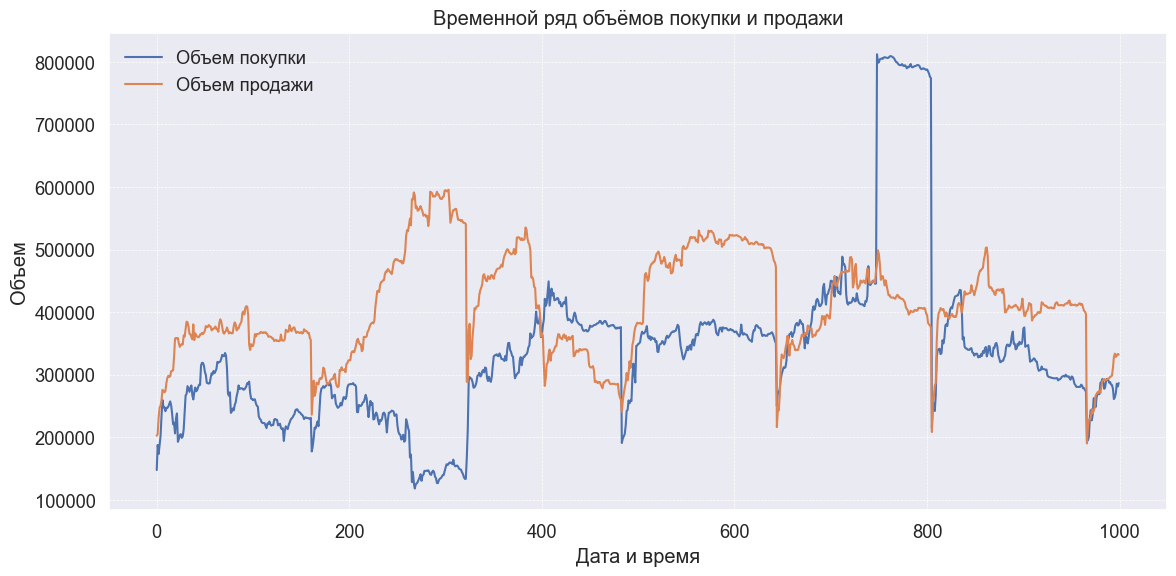

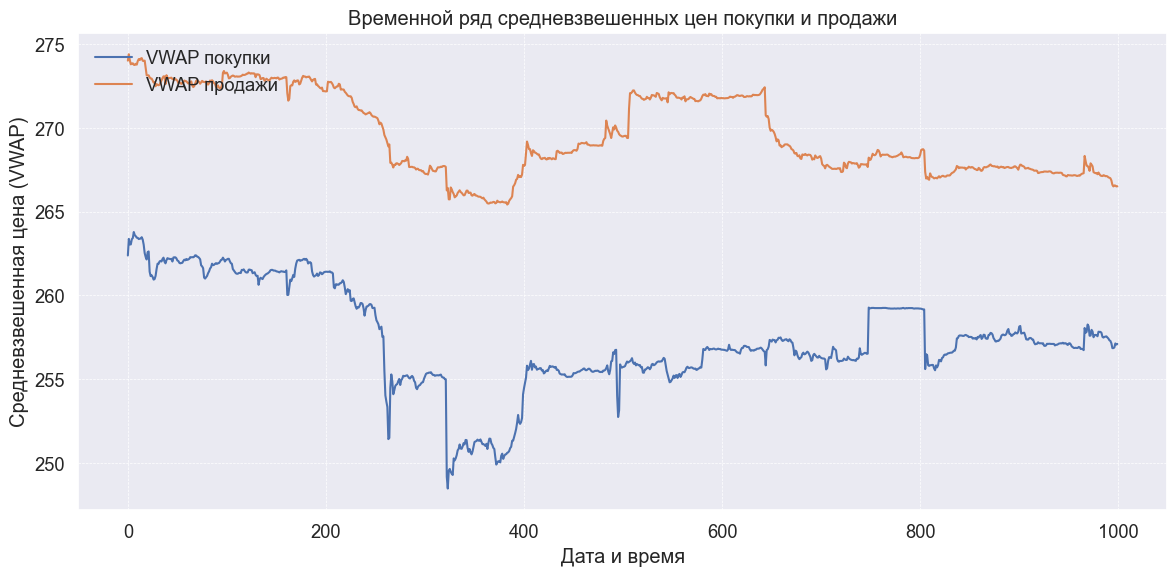

In [11]:
import matplotlib.pyplot as plt

# Установка шрифта для отображения кириллицы
plt.rcParams["font.family"] = "DejaVu Sans"
plt.style.use('seaborn-darkgrid')
sns.set(font_scale=1.2)  # увеличим шрифт
print()

# График временного ряда для spread_bbo, spread_lv10 и spread_1mio
plt.figure(figsize=(12, 6))
df[['spread_bbo', 'spread_lv10', 'spread_1mio']].plot(ax=plt.gca())
plt.title("Временной ряд для переменных спреда")
plt.xlabel("Дата и время")
plt.ylabel("Спред")
plt.legend(["Спред BBO", "Спред LV10", "Спред 1млн"], loc="upper left")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

# График временного ряда для vol_b и vol_s (объемы покупки и продажи)
plt.figure(figsize=(12, 6))
df[['vol_b', 'vol_s']].plot(ax=plt.gca())
plt.title("Временной ряд объёмов покупки и продажи")
plt.xlabel("Дата и время")
plt.ylabel("Объем")
plt.legend(["Объем покупки", "Объем продажи"], loc="upper left")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()
print()

# График временного ряда для vwap_b и vwap_s (средневзвешенные цены покупки и продажи)
plt.figure(figsize=(12, 6))
df[['vwap_b', 'vwap_s']].plot(ax=plt.gca())
plt.title("Временной ряд средневзвешенных цен покупки и продажи")
plt.xlabel("Дата и время")
plt.ylabel("Средневзвешенная цена (VWAP)")
plt.legend(["VWAP покупки", "VWAP продажи"], loc="upper left")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()
print()

,tradedate,vol_b,cumulative_volume
0,2024-10-01,40705542,40705542
1,2024-10-02,33502355,74207897
2,2024-10-03,57480469,131688366
3,2024-10-04,56826209,188514575
4,2024-10-07,87044840,275559415
5,2024-10-08,53176078,328735493
6,2024-10-09,9031350,337766843


,tradedate,vol_s,cumulative_volume
0,2024-10-01,57450911,57450911
1,2024-10-02,71492514,128943425
2,2024-10-03,62151837,191095262
3,2024-10-04,76979740,268075002
4,2024-10-07,65509258,333584260
5,2024-10-08,66204441,399788701
6,2024-10-09,9494868,409283569


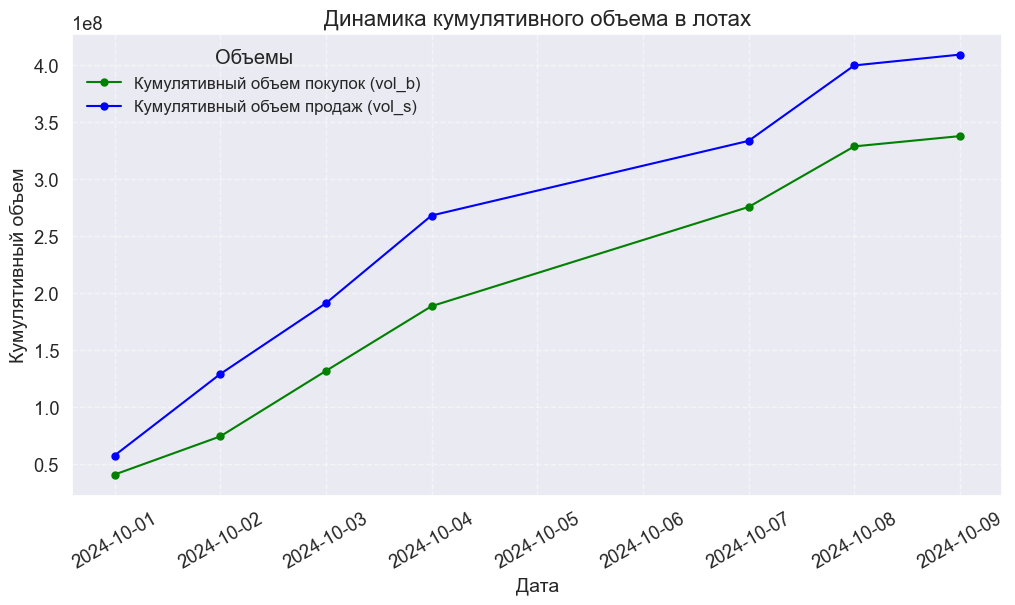

In [12]:
# Функция для вычисления и построения кумулятивного объема
def plot_cumulative_volume(column, color, label):
    # Группировка данных по дате и суммирование объемов
    daily_volume = df.groupby('tradedate')[column].sum().reset_index()
    
    # Проверка на пустые значения
    if daily_volume[column].isnull().all():
        print(f"Нет данных для {label}.")
        return

    # Вычисление кумулятивного объема
    daily_volume['cumulative_volume'] = daily_volume[column].cumsum()
    
    # Проверка на пустые кумулятивные значения
    if daily_volume['cumulative_volume'].isnull().all():
        print(f"Кумулятивные данные пусты для {label}.")
        return

    # Построение графика
    plt.plot(daily_volume['tradedate'], daily_volume['cumulative_volume'], 
             label=label, color=color, linestyle='-', marker='o', markersize=5)
    
    display(daily_volume)  # Вывод промежуточного результата для проверки

# Построение графиков для каждого из объемов
plt.figure(figsize=(12, 6))
plot_cumulative_volume('vol_b', 'green', 'Кумулятивный объем покупок (vol_b)')
plot_cumulative_volume('vol_s', 'blue', 'Кумулятивный объем продаж (vol_s)')

# Настройка графика
plt.title('Динамика кумулятивного объема в лотах', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Кумулятивный объем', fontsize=14)
plt.xticks(rotation=30)  # Повернем метки по оси X для удобства чтения
plt.legend(title='Объемы', fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.5)  
plt.show()


,tradedate,val_b,cumulative_value
0,2024-10-01,106616508358,106616508358
1,2024-10-02,86762203157,193378711515
2,2024-10-03,145730894877,339109606392
3,2024-10-04,145536881228,484646487620
4,2024-10-07,224528841400,709175329020
5,2024-10-08,136734414791,845909743811
6,2024-10-09,23258171771,869167915582


,tradedate,val_s,cumulative_value
0,2024-10-01,156831554742,156831554742
1,2024-10-02,192886234521,349717789263
2,2024-10-03,166002793745,515720583008
3,2024-10-04,209114018562,724834601570
4,2024-10-07,175744333507,900578935077
5,2024-10-08,177047966989,1077626902066
6,2024-10-09,25366686382,1102993588448


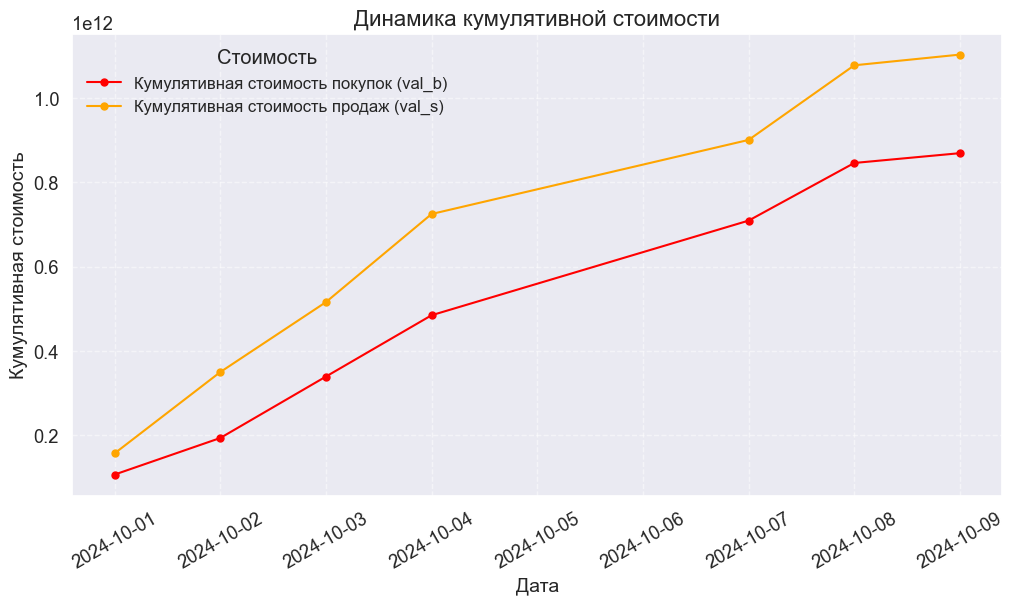

In [13]:
# Функция для вычисления и построения кумулятивной стоимости
def plot_cumulative_value(column, color, label):
    # Группировка данных по дате и суммирование стоимости
    daily_value = df.groupby('tradedate')[column].sum().reset_index()
    
    # Проверка на пустые значения
    if daily_value[column].isnull().all():
        print(f"Нет данных для {label}.")
        return

    # Вычисление кумулятивной стоимости
    daily_value['cumulative_value'] = daily_value[column].cumsum()
    
    # Проверка на пустые кумулятивные значения
    if daily_value['cumulative_value'].isnull().all():
        print(f"Кумулятивные данные пусты для {label}.")
        return

    # Построение графика
    plt.plot(daily_value['tradedate'], daily_value['cumulative_value'], 
             label=label, color=color, linestyle='-', marker='o', markersize=5)
    
    display(daily_value)  # Вывод промежуточного результата для проверки

# Построение графиков только для стоимости
plt.figure(figsize=(12, 6))
plot_cumulative_value('val_b', 'red', 'Кумулятивная стоимость покупок (val_b)')
plot_cumulative_value('val_s', 'orange', 'Кумулятивная стоимость продаж (val_s)')

# Настройка графика
plt.title('Динамика кумулятивной стоимости', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Кумулятивная стоимость', fontsize=14)

plt.xticks(rotation=30)  # Повернем метки по оси X для удобства чтения
plt.legend(title='Стоимость', fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.5)  
plt.show()
